In [2]:
import numpy as np
import os

from standard_tester import *

from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from runlmc.kern.matern32 import Matern32
from runlmc.kern.std_periodic import StdPeriodic
from runlmc.models.optimization import AdaDelta
from runlmc.models.gpy_lmc import GPyLMC

%matplotlib inline 
import matplotlib.pyplot as plt

In [19]:
np.random.seed(1234)
xss, yss, test_xss, test_yss, cols = foreign_exchange_18k()

In [4]:
sum(map(len, xss)), sum(map(len, test_xss)) # train,test size

(17908, 17908)

In [4]:
ks = [RBF(name='rbf0')]
ranks = [2]
cache_dir = '/tmp/'
inducing_points = [3]#np.arange(10, 150, 10)
num_runs = 1 # 5

In [5]:
nk = 4
ks = [Matern32(name='mat{}'.format(i)) for i in range(nk)]
ranks= [1 for _ in range(nk)]
time, smse, nlpd, lmc = runlmc(
    1, None,
    xss, yss, test_xss, test_yss,
    ks, ranks, {'max_it': 100, 'verbosity':10})

starting adadelta {'min_grad_ratio': 0.5, 'max_it': 100, 'step_rate': 1, 'offset': 0.0001, 'momentum': 0.5, 'verbosity': 10, 'roll': 2, 'decay': 0.9}
iteration       10 grad norm 1.0399e+03
finished adadelta optimization
            16 iterations
    3.6183e+02 final grad norm
    4.0035e+02 final MA(2) grad norm
    9.5384e+02 max MA(2) grad norm
    norm used inf


In [11]:
pred_yss, pred_vss = lmc.predict(test_xss)

In [ ]:
raise ValueError('load')
for i, ys in enumerate(test_yss):
    np.save('/home/vlad/Desktop/test_yss/{}'.format(i), ys)
for i, vs in enumerate(test_vss):
    np.save('/home/vlad/Desktop/test_vss/{}'.format(i), vs)
for x in ['K', 'pair_dists']:
    np.save('/home/vlad/Desktop/dense/'+x, getattr(lmc._dense(), x))
np.save('/home/vlad/Desktop/dense/L', lmc._dense().L[0])
np.save('/home/vlad/Desktop/dense/alpha', lmc._dense().deriv.alpha)
np.save('/home/vlad/Desktop/lmc', lmc.param_array)

In [20]:
time, smse,nlpd

(4066.132088236991, 0.0046601106582619062, -3.5245781083450702)

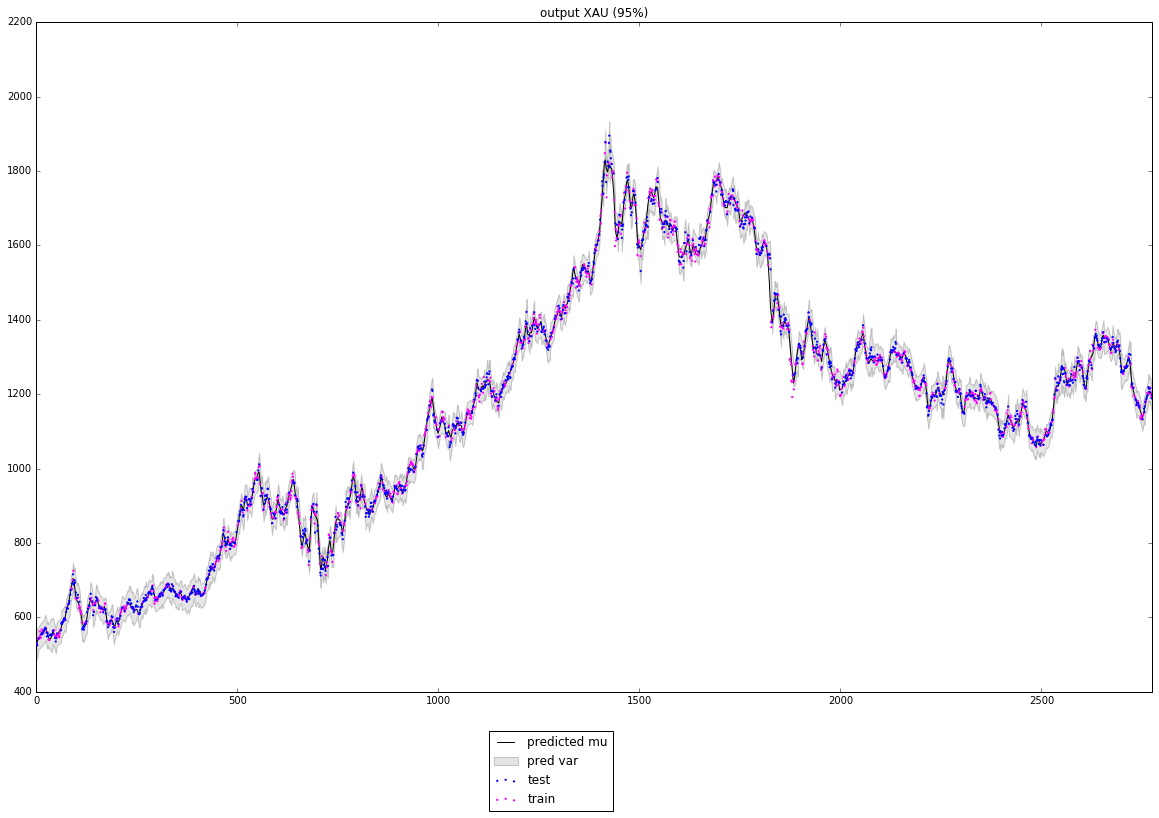

In [43]:
ix = 0
test_xs = test_xss[ix]
pred_ys = pred_yss[ix]
pred_vs = pred_vss[ix]
test_ys = test_yss[ix]

plt.figure(figsize=(20, 12))

# Prediction for LLGP
order = np.argsort(test_xs)
plt.plot(test_xs[order], pred_ys[order], c='black', label='predicted mu')
sd = np.sqrt(pred_vs)
top = test_ys + 2 * sd
bot = test_ys - 2 * sd
plt.fill_between(test_xs[order], bot[order], top[order], facecolor='grey', alpha=0.2, label='pred var')

# Test
marker_size = 5
plt.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11, label='test')

# Rest of image (training)
rest_xs = xss[ix]
rest_ys = yss[ix]
plt.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10, label='train')

plt.title('output {} (95%)'.format(cols[ix]))
plt.xlim([0, max(test_xs.max(), xss[ix].max())])
plt.legend(bbox_to_anchor=(.4, -.05), loc=2)
plt.savefig('/home/vlad/Desktop/pics/' + cols[ix])
plt.show()

In [ ]:
file_cached_vars = ['runlmc_times', 'runlmc_smses', 'runlmc_nlpds']
if all(os.path.isfile(cache_dir + file) for file in file_cached_vars):
    runlmc_times, runlmc_smses, runlmc_nlpds = [
        list(np.loadtxt(cache_dir + i)) for i in file_cached_vars]
else:
    runlmc_times, runlmc_smses, runlmc_nlpds = [], [], []
    for m in inducing_points:
        time, smse, nlpd, _ = runlmc(
            num_runs, m,
            xss, yss, test_xss, test_yss,
            ks, ranks, {'max_it': np.inf, 'verbosity':0})
        print('m', m, 'time', time, 'smse', smse, 'nlpd', nlpd)
        runlmc_times.append(time)
        runlmc_smses.append(smse)
        runlmc_nlpds.append(nlpd)
    for i in file_cached_vars:
        np.savetxt(cache_dir + i, eval(i))

In [ ]:
cogp_file_cached_vars = ['cogp_times', 'cogp_smses', 'cogp_nlpds']
if all(os.path.isfile(cache_dir + file) for file in cogp_file_cached_vars):
    cogp_times, cogp_smses, cogp_nlpds = [
        list(np.loadtxt(cache_dir + i)) for i in cogp_file_cached_vars]
else:
    cogp_num_runs = 2
    cogp_times, cogp_smses, cogp_nlpds = [], [], []
    for m in inducing_points:
        time, smse, nlpd = cogp_fx2007(cogp_num_runs, m)
        print('m', m, 'time', time, 'smse', smse, 'nlpd', nlpd)
        cogp_times.append(time)
        cogp_smses.append(smse)
        cogp_nlpds.append(nlpd)
    for i in cogp_file_cached_vars:
        np.savetxt(cache_dir + i, eval(i))        

In [ ]:
# note m means differnet things for LLGP and COGP
# -> use a time frontier graph
plt.plot(inducing_points, runlmc_times, label='LLGP')
plt.plot(inducing_points, cogp_times, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'run time vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('sec')
plt.show()
plt.plot(inducing_points, runlmc_smses, label='LLGP')
plt.plot(inducing_points, cogp_smses, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'standardized mean square error vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('smse')
plt.show()
shift = min(min(runlmc_nlpds), min(cogp_nlpds))
assert shift < 0
shift = int(abs(shift) * 2)
plt.semilogy(inducing_points, np.array(runlmc_nlpds) + shift, label='LLGP')
plt.semilogy(inducing_points, np.array(cogp_nlpds) + shift, label='COGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'shifted negative log predictive density vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('nlpd + {}'.format(shift))
plt.show()
plt.plot(inducing_points, np.array(runlmc_nlpds), label='LLGP')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'negative log predictive density vs $m$')
plt.xlabel(r'$m$')
plt.ylabel('nlpd')
plt.show()